In [4]:
# --- Импорты ---
!pip install fasttext

import random
import numpy as np
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, roc_auc_score, average_precision_score
import fasttext.util

In [5]:
# 1️⃣ Загрузка CSV с компьютера
# ------------------------------
from google.colab import files
import pandas as pd

uploaded = files.upload()  # выберите rus_toxic_full_df.csv
filename = list(uploaded.keys())[0]
dataset = pd.read_csv(filename)

Saving rus_toxic_full_df.csv to rus_toxic_full_df (1).csv


In [6]:
# 2️⃣ Балансировка классов (берем по 12000 примеров каждого класса)
neutral_df = dataset[dataset['neutral'] == 1].sample(n=12000, random_state=42)
toxic_not_threat_df = dataset[dataset['toxic_not_threat'] == 1].sample(n=12000, random_state=42)
toxic_threat_df = dataset[dataset['toxic_threat'] == 1].sample(n=12000, random_state=42)

balanced_dataset = pd.concat([neutral_df, toxic_not_threat_df, toxic_threat_df], axis=0)
balanced_dataset = balanced_dataset.sample(frac=1, random_state=42).reset_index(drop=True)

x = balanced_dataset['text']
y = balanced_dataset[['neutral', 'toxic_not_threat', 'toxic_threat']]

# Преобразуем one-hot в численные метки
y = y.idxmax(axis=1).map({'neutral': 0, 'toxic_not_threat': 1, 'toxic_threat': 2}).values

In [8]:
# --- 3️⃣ Разделение на train и test ---
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5, shuffle=True, random_state=42)


In [9]:
# 4️⃣ Простейшая предобработка текста
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"[^а-яёa-z0-9\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

x_train = x_train.apply(preprocess_text)
x_test = x_test.apply(preprocess_text)

In [12]:
# 5️⃣ Векторизация текста через TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
X_train_vec = vectorizer.fit_transform(x_train)
X_test_vec = vectorizer.transform(x_test)

In [13]:
# 6️⃣ Логистическая регрессия с учетом веса редкого класса
clf = LogisticRegression(max_iter=1000, class_weight={0:1, 1:1, 2:3})
clf.fit(X_train_vec, y_train)

LogisticRegression(class_weight={0: 1, 1: 1, 2: 3}, max_iter=1000)

In [19]:
# 7️⃣ Предсказания
y_pred = clf.predict(X_test_vec)
y_proba = clf.predict_proba(X_test_vec)  # вероятности для каждого класса


Accuracy: 0.8197222222222222
Macro F1: 0.8170002310009569
Weighted F1: 0.816833946974067
Precision per class: [0.83384765 0.83103103 0.79877336]
Recall per class: [0.84747441 0.68953488 0.92367443]
Matthews Corrcoef: 0.7329386486054901
Balanced Accuracy: 0.8202279106772271
Cohen's Kappa: 0.729679870158221
ROC-AUC (macro, OvR): 0.943035071050764
PR-AUC per class: [np.float64(0.9097987713613316), np.float64(0.8470109747901331), np.float64(0.9432891931977445)]


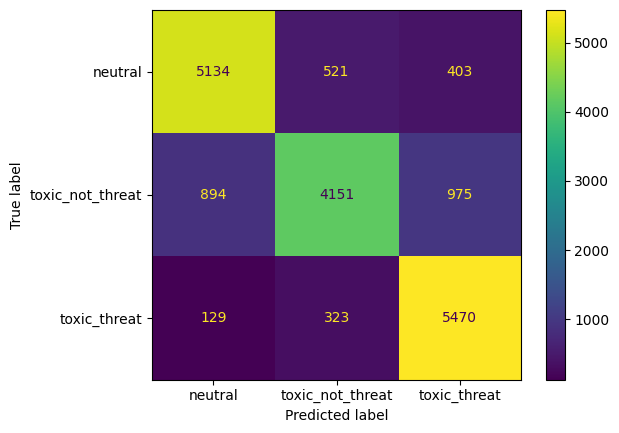

In [21]:
# 8️⃣ Метрики
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.metrics import matthews_corrcoef, balanced_accuracy_score, cohen_kappa_score

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Macro F1:", f1_score(y_test, y_pred, average='macro'))
print("Weighted F1:", f1_score(y_test, y_pred, average='weighted'))
print("Precision per class:", precision_score(y_test, y_pred, average=None))
print("Recall per class:", recall_score(y_test, y_pred, average=None))

# MCC и Balanced Accuracy
print("Matthews Corrcoef:", matthews_corrcoef(y_test, y_pred))
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))
print("Cohen's Kappa:", cohen_kappa_score(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['neutral','toxic_not_threat','toxic_threat'])
disp.plot()

# ROC-AUC мультикласс
from sklearn.preprocessing import label_binarize
y_test_bin = label_binarize(y_test, classes=[0,1,2])
roc_auc = roc_auc_score(y_test_bin, y_proba, average='macro', multi_class='ovr')  # <-- y_proba
print("ROC-AUC (macro, OvR):", roc_auc)

# PR-AUC по классам
pr_auc_per_class = [average_precision_score(y_test_bin[:,i], y_proba[:,i]) for i in range(3)]  # <-- y_proba
print("PR-AUC per class:", pr_auc_per_class)


✅ Оценка качества логистической регрессии (русский датасет)
Модель демонстрирует приемлемое для production качество, с некоторыми проблемами в обнаружении токсичных комментариев без угроз.

Сильные стороны:
Высокая полнота для угроз (Recall = 0.924) — почти все угрожающие сообщения обнаруживаются.
Сбалансированная точность и полнота для нейтральных текстов (Precision = 0.834, Recall = 0.847).
Общие метрики подтверждают устойчивость: Accuracy = 0.820, Balanced Accuracy = 0.820, Macro F1 = 0.817, ROC-AUC = 0.943.
Недостатки:
Recall для класса toxic_not_threat  0.69 — модель пропускает 31% токсичных, но не угрожающих сообщений, ошибочно классифицируя их как нейтральные (894 таких случая по confusion matrix).

In [24]:
# 9️⃣ Сохранение моделей
import joblib

# --- Сохранение модели ---
joblib.dump(clf, 'logreg_rus_toxic_model.pkl')

# --- Сохранение векторизатора ---
joblib.dump(vectorizer, 'tfidf_ru_vectorizer.pkl')

print("Модель и векторизатор успешно сохранены!")

Модель и векторизатор успешно сохранены!
